In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
import os
core_dir = os.path.join(os.getcwd(), '..', 'daphme')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import garden_city as gc
from garden_city import Building, Street, City, Agent, Population
import mobility_model as mmod
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS, FAST_STILL_PROBS, SLOW_STILL_PROBS

import pdb

Initialization of city and population

In [2]:
city = gc.load('garden-city.pkl')
population = Population(city)

# Demonstration: Stop Detection Metrics

Initialize agent with a true trajectory and a sparse sampled trajectory.

In [3]:
seed = 250

start_time = [datetime(2024, 6, 1, hour=8, minute=0) + timedelta(minutes=60*t) for t in range(5)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*5
location = ['h-x13-y9'] * 1 + ['h-x13-y8'] * 1 + ['w-x3-y13'] * 3

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gc.condense_destinations(destination)

Paco = Agent('Paco',
             'h-x13-y9',
             'w-x3-y13',
             city,
             destination_diary=destination)

population.add_agent(Paco)
population.generate_trajectory(Paco, T=96, seed=seed, dt=1)

hier_nhpp_params = (90, 45, 25)
Paco.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

Plot sparse sampled trajectory.

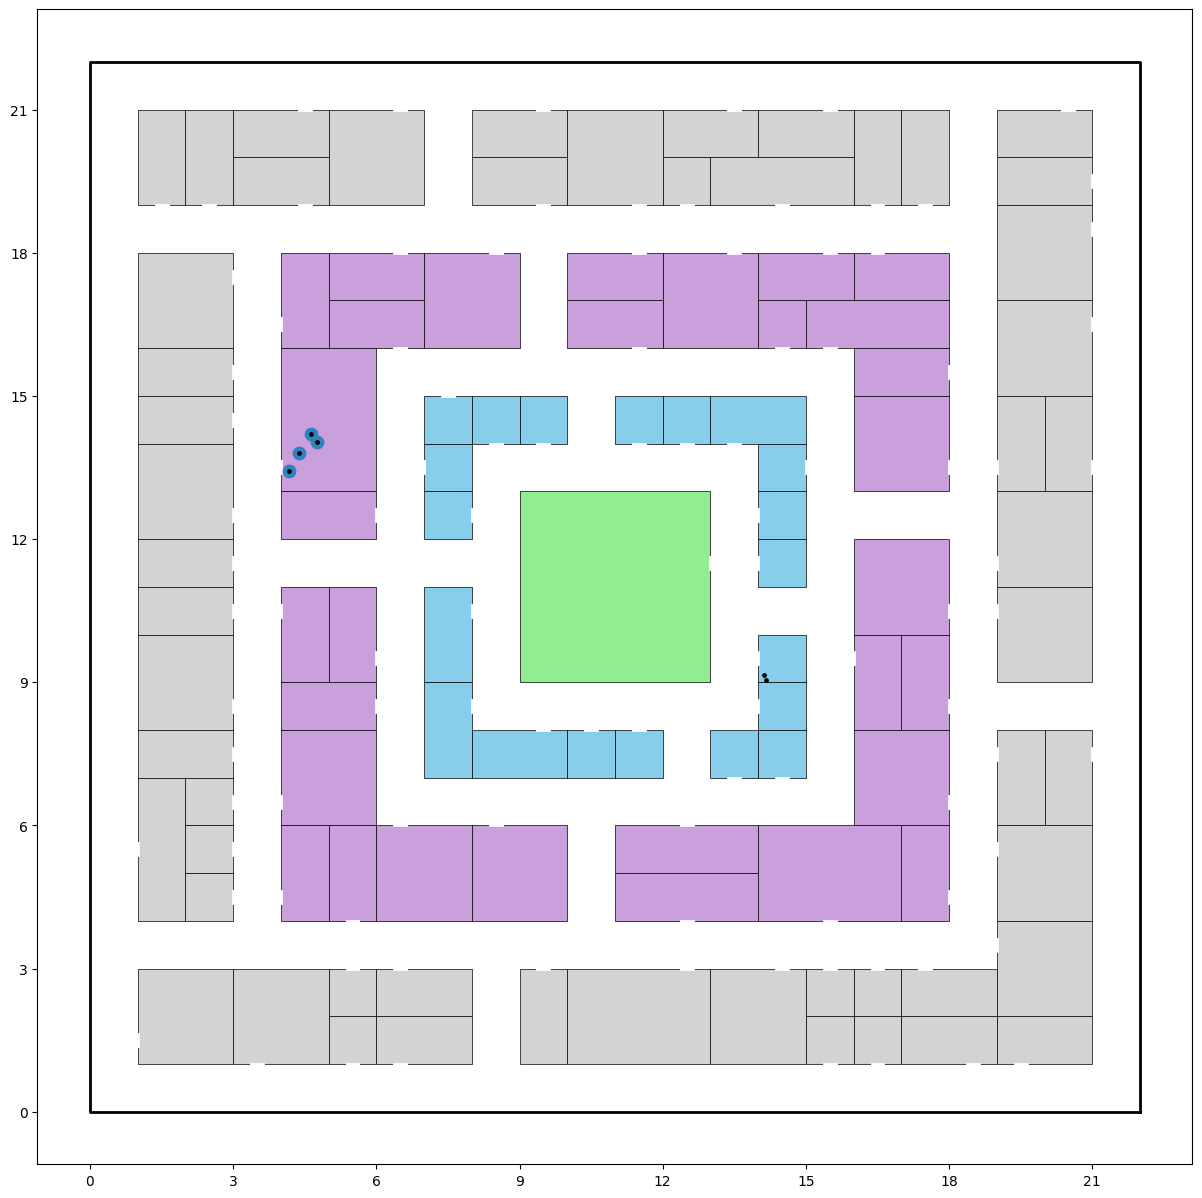

In [4]:
%matplotlib inline

dbscan_params = [(240, 2, 2), (60, 0.5, 3)]

dbscan_out = sd.temporal_dbscan(Paco.sparse_traj, *dbscan_params[1])

fig, ax = plt.subplots(figsize=(15, 15))

num_clusters = sum(dbscan_out.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = dbscan_out[dbscan_out.cluster == cid]
    cdata = Paco.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(Paco.sparse_traj.x, Paco.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

plt.show()

In [5]:
Paco_stop_table = sd.generate_stop_table(Paco.sparse_traj, dbscan_out)
Paco_stop_table['location'] = Paco_stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)

#Paco_stop_table

In [6]:
#Paco.diary

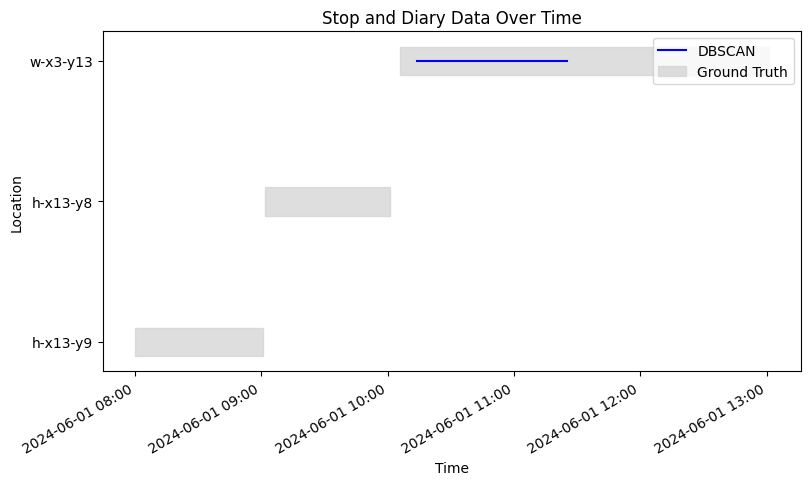

In [7]:
diary = Paco.diary.dropna().copy()
stop_table = Paco_stop_table.copy()

location_mapping = {loc: idx for idx, loc in enumerate(diary['location'].unique())}
diary['location_num'] = diary['location'].map(location_mapping)
stop_table['location_num'] = stop_table['location'].map(location_mapping)

# Create the plot
plt.figure(figsize=(9, 5))

# Plot stop_table
for idx, row in stop_table.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.plot([start_time, end_time], [row['location_num'], row['location_num']], color='blue', label='DBSCAN' if idx == 0 else "")

# Plot diary data with shaded rectangles
for idx, row in diary.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.fill_between([start_time, end_time], [row['location_num'] - 0.1, row['location_num'] - 0.1], [row['location_num'] + 0.1, row['location_num'] + 0.1], color='lightgrey', alpha=0.75, label='Ground Truth' if idx == 0 else "")

# Format the x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels automatically

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Location')
plt.title('Stop and Diary Data Over Time')
plt.yticks(ticks=list(location_mapping.values()), labels=list(location_mapping.keys()))

# Add legend
plt.legend()

# Show the plot
plt.show()

In [8]:
def expand_timestamps(df, start, end, gaps=False):
    """
    Expands timestamps to individual minutes
    """
    expanded_rows = []
    for _, row in df.iterrows():
        start_time = row['local_timestamp']
        for minute in range(row['duration']):
            expanded_rows.append({
                'timestamp': start_time + pd.Timedelta(minutes=minute),
                'stop_id': row['stop_id']
            })
    expanded = pd.DataFrame(expanded_rows)
    if gaps:
        expanded_timestamps = expanded['timestamp']
        full_range = pd.date_range(start=start, end=end, freq='T')
        gaps = full_range.difference(expanded_timestamps)
        gap_entries = pd.DataFrame({
            'timestamp': gaps,
            'stop_id': ['gap'] * len(gaps)
        })
        expanded = pd.concat([expanded, gap_entries]).sort_values(by='timestamp').reset_index(drop=True)
    return expanded


def find_stop_id(row, diary):
    """
    Maps a detected stop to a diary stop via overlapping location and timeframe.
    If multiple diary stops match those criteria, takes the first diary stop.
    """
    overlapping_stops = diary[
        (diary['location'] == row['location']) &
        (diary['local_timestamp'] <= row['end_time']) &
        (row['local_timestamp'] <= diary['end_time'])
    ]
    if not overlapping_stops.empty:
        return overlapping_stops.iloc[0]['stop_id']
    return None


def cluster_metrics(stop_table, diary, start, end):
    """
    Multiclass classification: compute precision, recall for each class separately,
    then use microaveraging to get the overall precision and recall.
    We could also try duration-weighted macroaveraging.
    """

    diary = diary.dropna().reset_index(drop=True)  # drop moves (location = None)

    # Calculate end times
    stop_table['end_time'] = stop_table['local_timestamp'] + pd.to_timedelta(stop_table['duration'], unit='m')
    diary['end_time'] = diary['local_timestamp'] + pd.to_timedelta(diary['duration'], unit='m')

    # Assign unique stop IDs to diary
    diary['stop_id'] = diary.index

    # Assign stop_id to stop_table
    stop_table['stop_id'] = stop_table.apply(find_stop_id, axis=1, diary=diary)

    # Clean up temporary columns
    stop_table = stop_table.drop(columns=['end_time'])
    diary = diary.drop(columns=['end_time'])

    # Count the number of rows in stop_table that match each stop_id in diary
    stop_counts = stop_table['stop_id'].value_counts().reset_index()
    stop_counts.columns = ['stop_id', 'stop_count']

    # Expand to minute-level
    expanded_stop_table = expand_timestamps(stop_table, start, end, gaps=False)
    expanded_diary = expand_timestamps(diary, start, end, gaps=False)

    # Merge the expanded dataframes on timestamps and locations
    merged = expanded_diary.merge(expanded_stop_table, on=['timestamp', 'stop_id'], how='outer', indicator=True)

    # Calculate precision and recall for each class
    stops = merged['stop_id'].unique()
    metrics_data = []

    for s in stops:
        s_merged = merged[merged['stop_id'] == s]
        s_tp = s_merged[s_merged['_merge'] == 'both'].shape[0]
        s_fp = s_merged[s_merged['_merge'] == 'right_only'].shape[0]
        s_fn = s_merged[s_merged['_merge'] == 'left_only'].shape[0]

        metrics_data.append({
            'stop_id': s,
            'tp': s_tp,
            'fp': s_fp,
            'fn': s_fn,
            'precision': s_tp / (s_tp + s_fp) if (s_tp + s_fp) != 0 else 0,
            'recall': s_tp / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0
        })

    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = diary.merge(metrics_df, on=['stop_id'], how='outer')
    metrics_df = metrics_df.merge(stop_counts, on=['stop_id'], how='outer')
    metrics_df = metrics_df.set_index('stop_id')
    metrics_df['stop_count'] = metrics_df['stop_count'].fillna(0).astype(int)

    tp = metrics_df['tp'].sum()
    fp = metrics_df['fp'].sum()
    fn = metrics_df['fn'].sum()

    # Calculate micro-averaged precision and recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate macro-average precision and recall, weighted by duration of stop
    total_duration = metrics_df['duration'].sum()
    weighted_precision = (metrics_df['precision'] * metrics_df['duration']).sum() / total_duration
    weighted_recall = (metrics_df['recall'] * metrics_df['duration']).sum() / total_duration

    # Tabulate number of missed and splitted stops
    num_missed = metrics_df[metrics_df['stop_count'] == 0].shape[0]
    num_split = metrics_df[metrics_df['stop_count'] >= 2].shape[0]

    metrics = {
        "Precision": precision,
        "Recall": recall,
        "Weighted Precision": weighted_precision,
        "Weighted Recall": weighted_recall,
        "Missed": num_missed,
        "Split": num_split
    }

    return metrics_df, metrics

In [9]:
start = pd.Timestamp('2024-06-01 8:00:00')
end = pd.Timestamp('2024-06-01 13:00:00')

metrics_df, metrics = cluster_metrics(stop_table, Paco.diary, start, end)
metrics

{'Precision': 1.0,
 'Recall': 0.24067796610169492,
 'Weighted Precision': 0.5932203389830508,
 'Weighted Recall': 0.24067796610169492,
 'Missed': 2,
 'Split': 0}

In [10]:
metrics_df

,unix_timestamp,local_timestamp,duration,location,tp,fp,fn,precision,recall,stop_count
stop_id,,,,,,,,,,
0,1717228800,2024-06-01 08:00:00,61,h-x13-y9,0,0,61,0.0,0.000000,0
1,1717232520,2024-06-01 09:02:00,59,h-x13-y8,0,0,59,0.0,0.000000,0
2,1717236360,2024-06-01 10:06:00,175,w-x3-y13,71,0,104,1.0,0.405714,1


# Curves

Recall v.s. Sampling Sparsity

In [15]:
seeds = range(200, 210)
sparsity_range = range(1, 30)

#results = pd.DataFrame(columns=['beta_ping', 'recall', 'precision'])
results = np.zeros((len(seeds), len(sparsity_range), 3))

start_time = [datetime(2024, 6, 1, hour=8, minute=0) + timedelta(minutes=60*t) for t in range(5)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*5
location = ['h-x13-y9'] * 1 + ['h-x13-y8'] * 1 + ['w-x3-y13'] * 3

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gc.condense_destinations(destination)

Bethany = Agent('Bethany',
                'h-x13-y9',
                'w-x3-y13',
                city,
                destination_diary=destination)

population.add_agent(Bethany)

for i, seed in enumerate(seeds):
    population.generate_trajectory(Bethany, T=96, seed=seed, dt=1)

    print(seed)

    for j, beta_ping in enumerate(sparsity_range):
        hier_nhpp_params = (90, 45, beta_ping)
        dbscan_params = (60, 0.5, 3)

        Bethany.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)
        dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_params)

        stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

        if stop_table.empty:
            results[i, j, 0] = beta_ping
            results[i, j, 1] = 0  # Recall
            results[i, j, 2] = 0  # Precision
            continue

        stop_table['location'] = stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)

        start = pd.Timestamp('2024-06-01 8:00:00')
        end = pd.Timestamp('2024-06-01 13:00:00')

        metrics_df, metrics = cluster_metrics(stop_table, Bethany.diary, start, end)
        results[i, j, 0] = beta_ping
        results[i, j, 1] = metrics['Recall']
        results[i, j, 2] = metrics['Precision']

results_avg = np.mean(results, axis=0)
results_avg = pd.DataFrame(results_avg, columns=['beta_ping', 'recall', 'precision'])


Agent identifier already exists in population. Replacing corresponding agent.
200
201
202
203
204
205
206
207
208
209


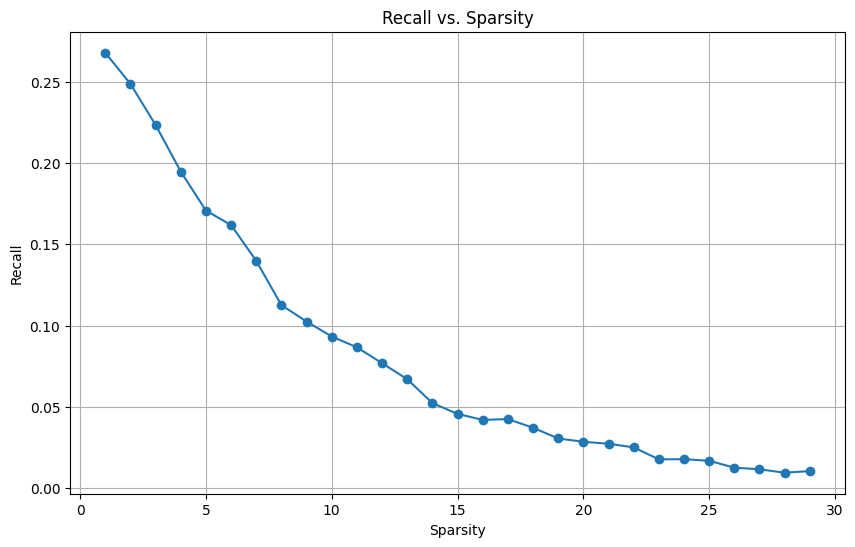

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(results_avg['beta_ping'], results_avg['recall'], marker='o')
plt.xlabel('Sparsity')
plt.ylabel('Recall')
plt.title('Recall vs. Sparsity')
plt.grid(True)
plt.show()

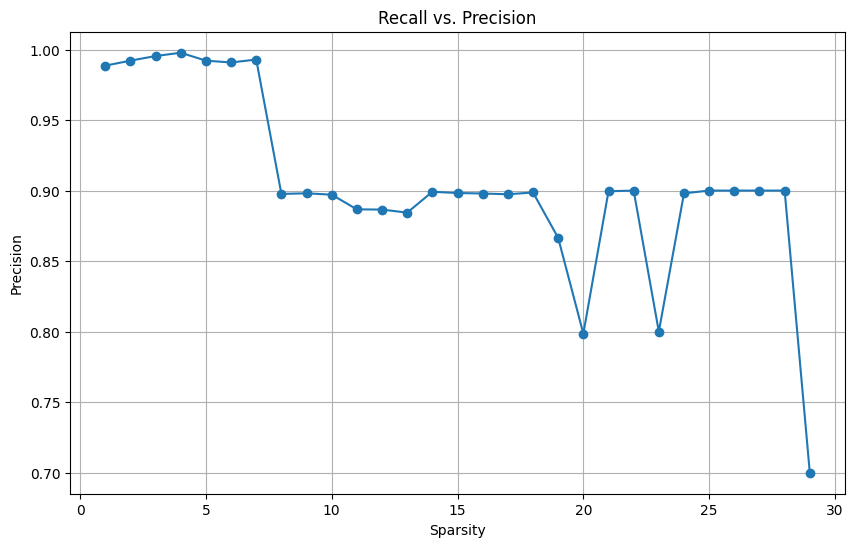

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(results_avg['beta_ping'], results_avg['precision'], marker='o')
plt.xlabel('Sparsity')
plt.ylabel('Precision')
plt.title('Recall vs. Precision')
plt.grid(True)
plt.show()